# Health Prediction using Fully Homomorphic Encryption

Processing medical data has long posed a significant challenge in the realm of machine learning primarily due to the sensitive nature of the data and the rigorous regulations safeguarding patient privacy.

This notebook showcases the use of Concrete ML for a diagnosis task that relies on sensitive information: patient symptoms. Additionally, the notebook provides guidance on how to select the most appropriate Concrete model for real-life deployment in this [HuggingFace space]().

<!--
# Add the hugging face space link
# FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/3746
 -->

### Import libraries

In [1]:
import random
import shutil
from pathlib import Path
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from preprocessing import prepare_data
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

### Data-set


The data used are available via this [link](https://github.com/anujdutt9/Disease-Prediction-from-Symptoms/tree/master/dataset).


For the sake of simplicity, we performed a preliminary preprocessing on the data, such as correcting column names and encoding the target column that we saved in [Training_preprocessed.csv](./data/Training_preprocessed.csv) for the training set and [Testing_preprocessed.csv](./data/Testing_preprocessed.csv) for test set.

In [2]:
# Load the train and testing sets

df_train, df_test = prepare_data()

TARGET_COLUMN = ["prognosis_encoded", "prognosis"]

y_train = df_train[TARGET_COLUMN[0]].values.flatten()
y_test = df_test[TARGET_COLUMN[0]].values.flatten()

X_train = df_train.drop(TARGET_COLUMN, axis=1)
X_test = df_test.drop(TARGET_COLUMN, axis=1)

df_train.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurving,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,prognosis_encoded
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14.0


In [3]:
# There are 132 distinct symptoms and 41 unique diseases

print(
    f"The dataset contains: {X_train.shape[1]} distinct symptoms and "
    f"{len(np.unique(y_train))} unique diseases."
)

The dataset contains: 132 distinct symptoms and 41 unique diseases.


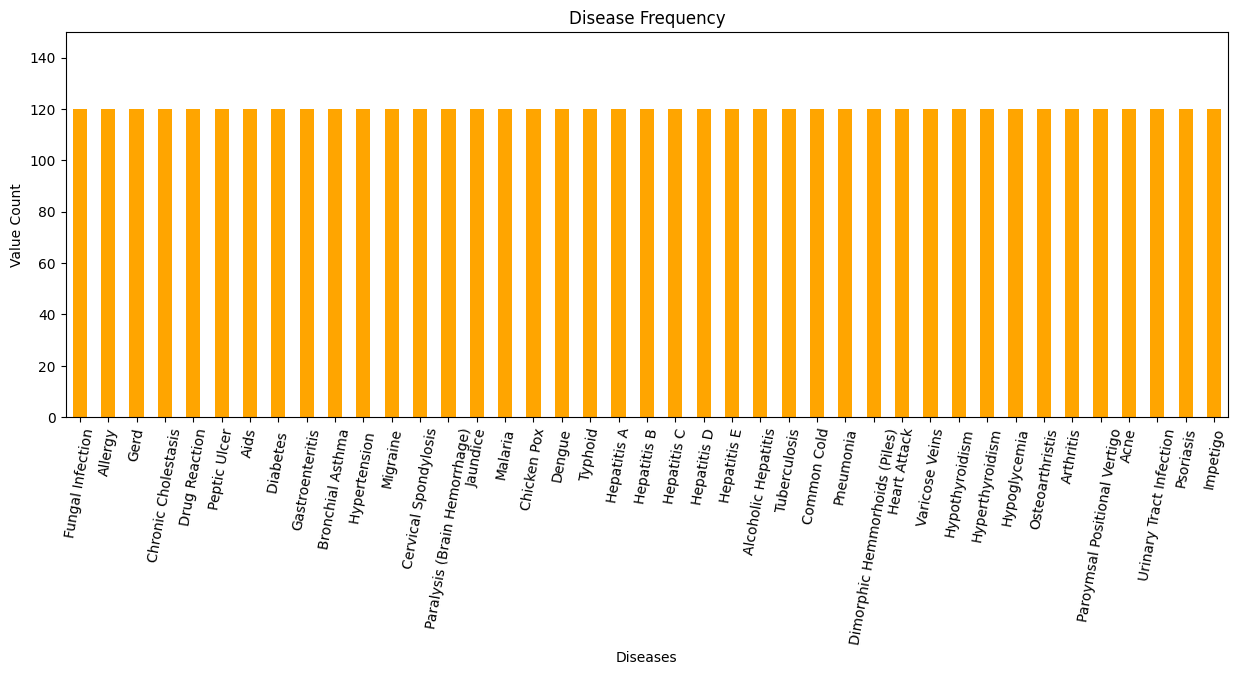

In [4]:
# The Training data-set is well-balanced

value_counts = df_train[TARGET_COLUMN[1]].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 5))

ax = value_counts.plot.bar(color="orange")
ax.set_xlabel("Diseases")
ax.set_ylim(0, 150)
ax.set_ylabel("Value Count")
ax.set_title("Disease Frequency")

plt.xticks(rotation=80)
plt.show()

## Accuracy vs speed trade-off for FHE ML models

FHE programs are slower due to various factors, including the high cost of PBS operations and current hardware limitations. However, ongoing research is actively improving the performance of FHE to overcome these constraints. To mitigate these constraints in real-life use-cases, developers must search for an optimal model configuration that obtains an interesting trade-off between speed and accuracy. To do so, we use grid search, evaluating the model using FHE simulation mode.

In [5]:
param_grid = {
    "n_bits": [2, 3, 4, 5, 6, 7],
    "max_depth": [1, 2, 3],
    "n_estimators": [1, 2, 3, 5],
}
concrete_clf = ConcreteXGBClassifier(n_jobs=-1)
grid_search = GridSearchCV(
    concrete_clf,
    param_grid,
    cv=4,
    verbose=1,
    n_jobs=-1,
).fit(X_train, y_train)

# The best model
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2%}")

Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best parameters: {'max_depth': 3, 'n_bits': 7, 'n_estimators': 2}
Best score: 100.00%


The best model configuration may not necessarily mean the best performing model in the FHE realm. To highlight this nuance, we measure the inference timing for a single random sample in real FHE mode for each configuration.

In [6]:
# Take a random input as a test case to measure the execution time of all the Concrete ML models
fhe_inference_time = []
random_int = random.randint(0, len(X_test) - 1)
random_x, random_y = X_test.iloc[random_int].values[np.newaxis, :], y_test[random_int]

print(
    f"Prediction: {random_y} -> "
    f"{df_test[df_test['prognosis_encoded'] == random_y]['prognosis'].values[0]}"
)

Prediction: 8.0 -> Chronic Cholestasis


In [7]:
# Select the relevant columns to be displayed
columns_to_display = [
    "param_n_bits",
    "param_max_depth",
    "param_n_estimators",
    "mean_test_score",
    "std_test_score",
]

columns_to_be_renamed = {
    "param_n_bits": "n_bits",
    "param_max_depth": "max_depth",
    "param_n_estimators": "n_estimators",
}

# Save the grid search results as a DataFrame
grid_results = pd.DataFrame(grid_search.cv_results_)[columns_to_display]

# Sort the results by mean_test_score in descending order and rename some columns
sorted_results = grid_results.sort_values(by="mean_test_score", ascending=False).rename(
    columns=columns_to_be_renamed
)

for _, param in tqdm(sorted_results[["n_bits", "max_depth", "n_estimators"]].iterrows()):
    # Instanciation
    xgb_clf = ConcreteXGBClassifier(**dict(param))
    # Training
    xgb_clf.fit(X_train, y_train)
    fhe_circuit = xgb_clf.compile(X_train)
    # Key generation
    fhe_circuit.client.keygen(force=False)
    # Inference
    start_time = time()
    y_pred = xgb_clf.predict(random_x, fhe="execute")

    fhe_inference_time.append(time() - start_time)

sorted_results["fhe_inference_time"] = fhe_inference_time

0it [00:00, ?it/s]

For each Concrete ML model, we display its score along with the corresponding inference timing.
This enables us to evaluate the model's effectiveness in terms of performance and its computational efficiency.

In [8]:
index = 5

sorted_results.style.background_gradient(
    subset=["n_bits", "mean_test_score", "fhe_inference_time"]
).apply(
    lambda index: ["background-color: green"] * len(index), axis=1, subset=pd.IndexSlice[[index], :]
)

,n_bits,max_depth,n_estimators,mean_test_score,std_test_score,fhe_inference_time
69,7,3,2,1.000000,0.000000,7.949376
71,7,3,5,0.998780,0.001220,27.149234
70,7,3,3,0.998780,0.001220,18.267641
67,6,3,5,0.998780,0.001220,8.221773
66,6,3,3,0.996341,0.003659,4.072008
65,6,3,2,0.996341,0.003659,2.944537
47,7,2,5,0.996341,0.003659,13.709555
46,7,2,3,0.993902,0.006098,8.189699
45,7,2,2,0.993902,0.006098,5.682459
43,6,2,5,0.993902,0.006098,4.739243


As the results show in the table below, the most accurate models are also the ones that have the longest inference times in FHE.

However, less complex configurations could provide a reasonable compromise between efficiency and accuracy.

### Most optimal model in FHE

In [9]:
# The most optimal model in the FHE realm is:

optimal_param = {"max_depth": 1, "n_bits": 3, "n_estimators": 2, "n_jobs": -1}

concrete_xgb_clf = ConcreteXGBClassifier(**optimal_param)

concrete_xgb_clf.fit(X_train, y_train)

fhe_circuit = concrete_xgb_clf.compile(X_train)

fhe_circuit.client.keygen(force=False)

In [10]:
# Simulated FHE mode

start_time = time()
y_pred = concrete_xgb_clf.predict(random_x, fhe="simulate")
print(f"Inference timing: {time() - start_time:.3f} s")
print(
    f"Prediction: {y_pred[0]} -> "
    f"{df_test[df_test['prognosis_encoded'] == y_pred[0]]['prognosis'].values[0]}"
)

Inference timing: 0.007 s
Prediction: 8.0 -> Chronic Cholestasis


In [11]:
# FHE mode

start_time = time()
y_pred = concrete_xgb_clf.predict(random_x, fhe="execute")
print(f"Inference timing: {time() - start_time:.3f} s")
print(
    f"Prediction: {y_pred[0]} -> "
    f"{df_test[df_test['prognosis_encoded'] == y_pred[0]]['prognosis'].values[0]}"
)

Inference timing: 0.203 s
Prediction: 8.0 -> Chronic Cholestasis


### Save the model for deployment using Concrete ML

Now that we have selected the optimal model, we can save it.

In [12]:
from concrete.ml.deployment import FHEModelDev

path_to_model = Path("./health_prediction/deployment").resolve()

if path_to_model.exists():
    shutil.rmtree(path_to_model)

dev = FHEModelDev(path_to_model, concrete_xgb_clf)
dev.save(via_mlir=True)

### Conclusion

This notebook shows how to carefully choose a Concrete ML model for deployment by highlighting the subtleties between the most accurate and the optimal model within FHE constraints.

By leveraging fully homomorphic encryption (FHE), it becomes possible to process sensitive data, such as patient symptoms and their diagnosis, while preserving individuals' privacy and enabling advancements in the healthcare domain.